In [229]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.interpolate import interp1d

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Read file
bitcoinPriceData = pd.read_csv('bitcoin_historical_Oct2024.csv')

priceFull = bitcoinPriceData[['Open', 'High', 'Low', 'Close']][::-1].to_numpy()
timeFull = pd.to_datetime(bitcoinPriceData['Start'][::-1].to_numpy())
price_df = pd.DataFrame(priceFull, index=timeFull, columns=['Open', 'High', 'Low', 'Close'])
price_df.index.name = 'Date'



# Set parameters --------------
t0 = '2009-01-03' # Bitcoin genesis date
start_date = '2014-06-01' # Start date for retrieving price data
end_date = (datetime.today() + pd.to_timedelta(1, unit='D')).strftime('%Y-%m-%d') # End date for retrieving price data
k_PL = 5.7 # Power Law Exponent
T_span = np.arange(180,450,15)  # Time span in days for calculating PLRR
ticker_name = 'BTC-USD' # ticker name for bitcoin price


# Get bitcoin price from yahoo finance -----------------------
# price_df = yf.download(ticker_name, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close']].copy()
# Convert t0 to datetime
t0_datetime = pd.to_datetime(t0)

# Calculate timeDays by subtracting t0 from the index
price_df['TimeDays'] = (price_df.index - t0_datetime).days
# Calculate daily log Return
price_df['LogReturn'] = np.log(0.5*(price_df['High']+price_df['Low'])).diff()
# Calculate daily log time difference
price_df['LogTimeDiff'] = np.log(price_df['TimeDays']).diff()


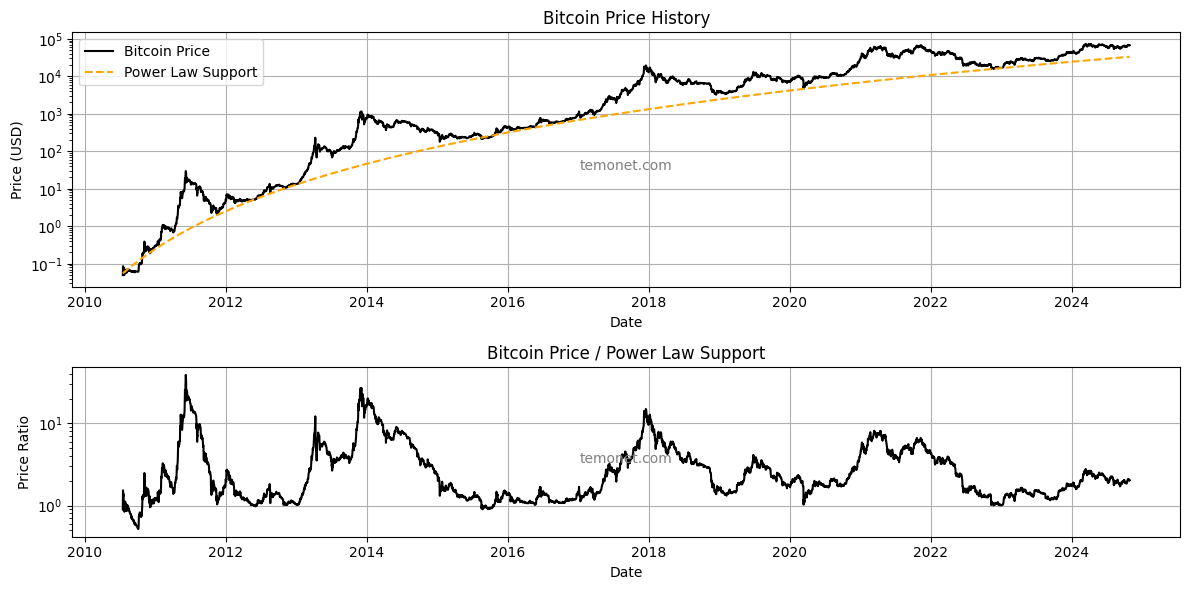

In [230]:
PLawLow = 1.2e-17*price_df['TimeDays']**5.7


fig, axs = plt.subplots(2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 2]})  # Adjusted height ratio for plots

axs[0].semilogy(price_df.index, price_df['Close'], label='Bitcoin Price', color='black')
axs[0].semilogy(price_df.index, PLawLow, label='Power Law Support', linestyle='--', color='orange')
axs[0].set_title('Bitcoin Price History')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()
axs[0].grid(True)  # Added grid
axs[0].text(0.5, 0.5, 'temonet.com', transform=axs[0].transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')

axs[1].semilogy(price_df.index, price_df['Close'] / PLawLow, color='black')
axs[1].set_title('Bitcoin Price / Power Law Support')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price Ratio')
axs[1].grid(True)  # Added grid
axs[1].text(0.5, 0.5, 'temonet.com', transform=axs[1].transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')

plt.tight_layout()
plt.savefig('/Users/ashwinsridhar/Documents/Projects/assridha.github.io/assets/img/price_history.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()



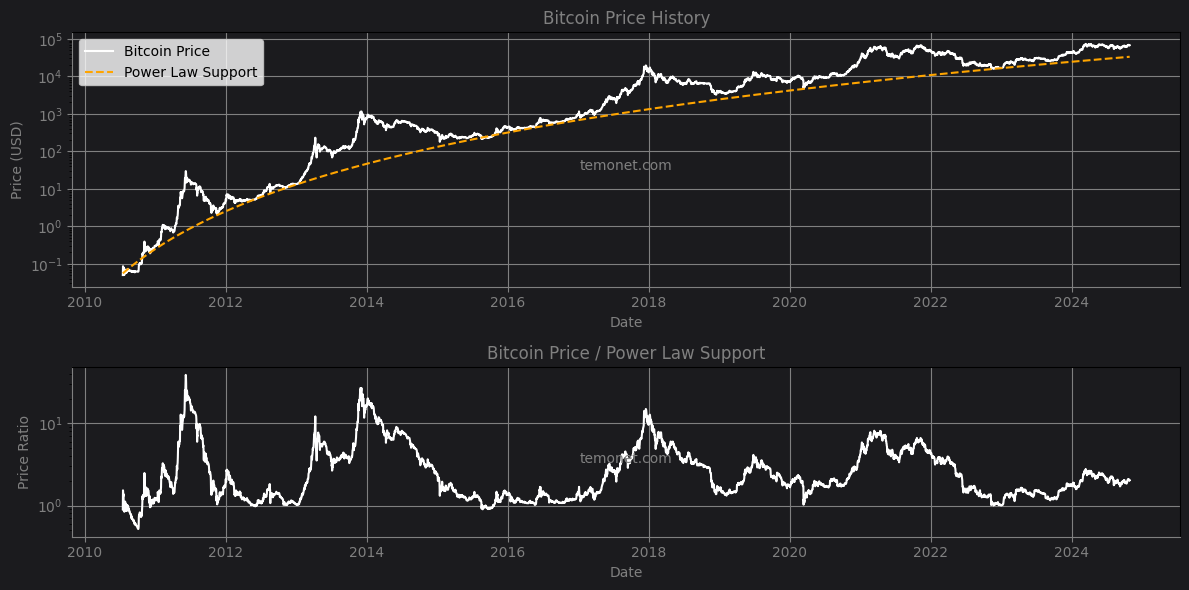

In [231]:
fig, axs = plt.subplots(2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 2]}, facecolor='#1b1b1e', edgecolor='#1b1b1e')

axs[0].set_facecolor('#1b1b1e')
axs[0].semilogy(price_df.index, price_df['Close'], label='Bitcoin Price', color='white')
axs[0].semilogy(price_df.index, PLawLow, label='Power Law Support', linestyle='--', color='orange')
axs[0].set_title('Bitcoin Price History', color='gray')
axs[0].set_xlabel('Date', color='gray')
axs[0].set_ylabel('Price (USD)', color='gray')
axs[0].tick_params(axis='x', colors='gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].spines['left'].set_color('gray')
axs[0].legend()
axs[0].grid(True, color='gray')  # Added grid with gray color
axs[0].text(0.5, 0.5, 'temonet.com', transform=axs[0].transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')


axs[1].set_facecolor('#1b1b1e')
axs[1].semilogy(price_df.index, price_df['Close'] / PLawLow, color='white')
axs[1].set_title('Bitcoin Price / Power Law Support', color='gray')
axs[1].set_xlabel('Date', color='gray')
axs[1].set_ylabel('Price Ratio', color='gray')
axs[1].tick_params(axis='x', colors='gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].spines['left'].set_color('gray')
axs[1].grid(True, color='gray')  # Added grid with gray color
axs[1].text(0.5, 0.5, 'temonet.com', transform=axs[1].transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')

plt.tight_layout()
plt.savefig('/Users/ashwinsridhar/Documents/Projects/assridha.github.io/assets/img/price_history_dark.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

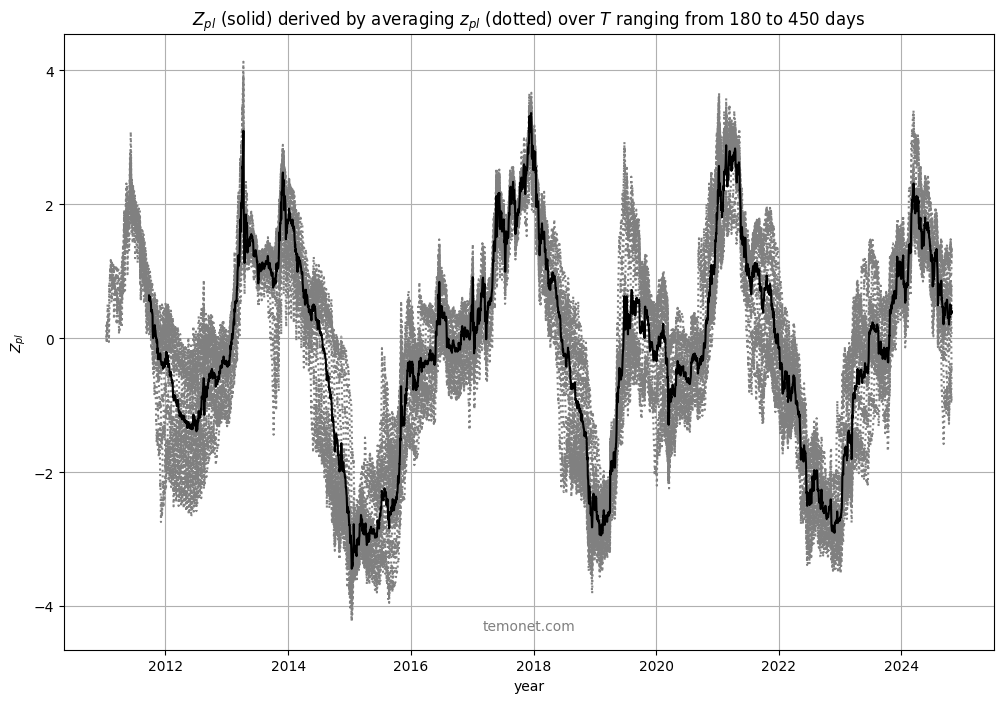

In [232]:
price_df['value'] = np.zeros(len(price_df))
plt.figure(figsize=(12, 8))
for jj in np.arange(0,len(T_span)):
    # Calculate rolling mean to log Return
    price_df['MeanLogReturn'] = price_df['LogReturn'].rolling(T_span[jj]).mean()
    # Apply rolling mean to log time difference
    price_df['MeanLogTimeDiff'] = price_df['LogTimeDiff'].rolling(T_span[jj]).mean()
    # Calculate rolling standard deviation
    price_df['LogSDev'] = price_df['LogReturn'].rolling(T_span[jj]).std()
    # Calculate Power Law Residual Ratio with scaling definition 1 (value)
    price_df['value'] += (1/len(T_span))*np.sqrt(T_span[jj])*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'])/price_df['LogSDev']
    PLRR_curr = np.sqrt(T_span[jj])*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'])/price_df['LogSDev']
    plt.plot(price_df.index, PLRR_curr,color = 'gray',linestyle = ':')

plt.plot(price_df.index,price_df['value'],color='black')
plt.grid(True)
plt.xlabel('year')
plt.ylabel('$Z_{pl}$')
plt.title('$Z_{pl}$ (solid) derived by averaging $z_{pl}$ (dotted) over $T$ ranging from 180 to 450 days')
plt.text(0.5, 0.05, 'temonet.com', transform=plt.gca().transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')
plt.savefig('/Users/ashwinsridhar/Documents/Projects/assridha.github.io/assets/img/Zpl_averaging.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()


# Create two dataframes: one for price history and one for PLRR indicator
price_history_df = price_df[['Open', 'High', 'Low', 'Close','value','TimeDays']]
plrr_df = price_df[['value']]

# Remove NaN and null values from both dataframes
plrr_df = plrr_df.dropna(how='all')
price_history_df = price_history_df.dropna(subset=['value'])



price_history_df = price_history_df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'})
price_history_df.index.name = 'time'
plrr_df.index.name = 'time'



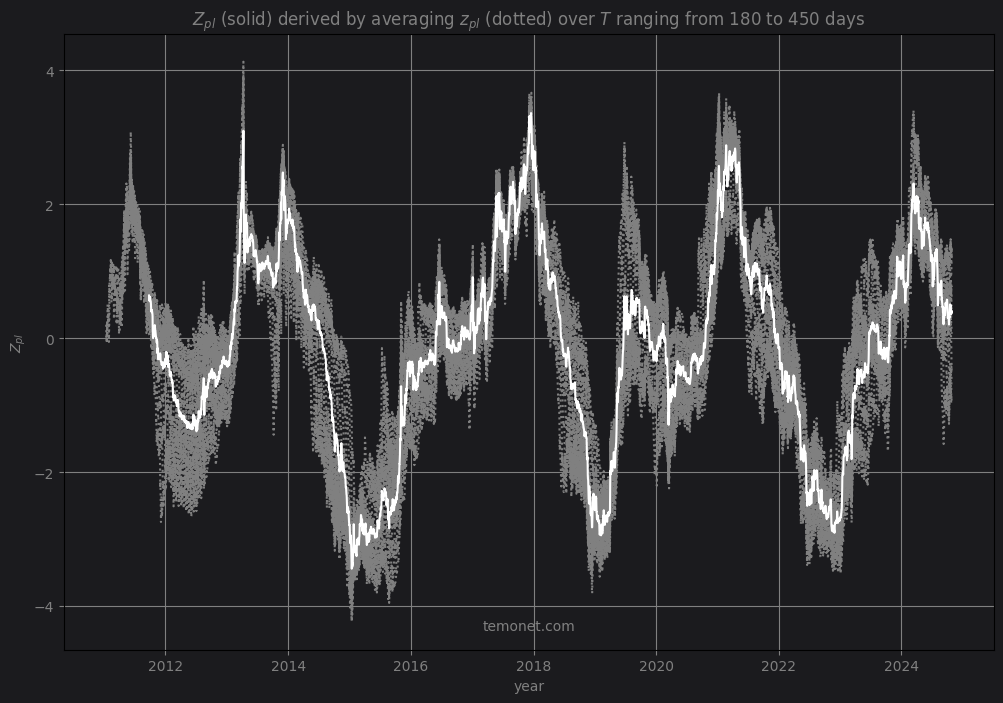

In [233]:
price_df['value'] = np.zeros(len(price_df))
plt.figure(figsize=(12, 8), facecolor='#1b1b1e', edgecolor='#1b1b1e')
ax = plt.axes()
 
# Setting the background color of the plot 
# using set_facecolor() method
ax.set_facecolor("#1b1b1e")
for jj in np.arange(0,len(T_span)):
    # Calculate rolling mean to log Return
    price_df['MeanLogReturn'] = price_df['LogReturn'].rolling(T_span[jj]).mean()
    # Apply rolling mean to log time difference
    price_df['MeanLogTimeDiff'] = price_df['LogTimeDiff'].rolling(T_span[jj]).mean()
    # Calculate rolling standard deviation
    price_df['LogSDev'] = price_df['LogReturn'].rolling(T_span[jj]).std()
    # Calculate Power Law Residual Ratio with scaling definition 1 (value)
    price_df['value'] += (1/len(T_span))*np.sqrt(T_span[jj])*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'])/price_df['LogSDev']
    PLRR_curr = np.sqrt(T_span[jj])*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'])/price_df['LogSDev']
    plt.plot(price_df.index, PLRR_curr,color = 'gray',linestyle = ':')

plt.plot(price_df.index,price_df['value'],color='white')
plt.grid(True, color='gray')
plt.xlabel('year', color='gray')
plt.ylabel('$Z_{pl}$', color='gray')
plt.title('$Z_{pl}$ (solid) derived by averaging $z_{pl}$ (dotted) over $T$ ranging from 180 to 450 days', color='gray')
plt.text(0.5, 0.05, 'temonet.com', transform=plt.gca().transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')
plt.xticks(color='gray')
plt.yticks(color='gray')
plt.gca().tick_params(axis='x', colors='gray')
plt.gca().tick_params(axis='y', colors='gray')
plt.savefig('/Users/ashwinsridhar/Documents/Projects/assridha.github.io/assets/img/Zpl_averaging_invert.png', bbox_inches='tight', pad_inches=0.1, dpi=300, facecolor='#1b1b1e', edgecolor='#1b1b1e')
plt.show()


# Create two dataframes: one for price history and one for PLRR indicator
price_history_df = price_df[['Open', 'High', 'Low', 'Close','value','TimeDays']]
plrr_df = price_df[['value']]

# Remove NaN and null values from both dataframes
plrr_df = plrr_df.dropna(how='all')
price_history_df = price_history_df.dropna(subset=['value'])



price_history_df = price_history_df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'})
price_history_df.index.name = 'time'
plrr_df.index.name = 'time'


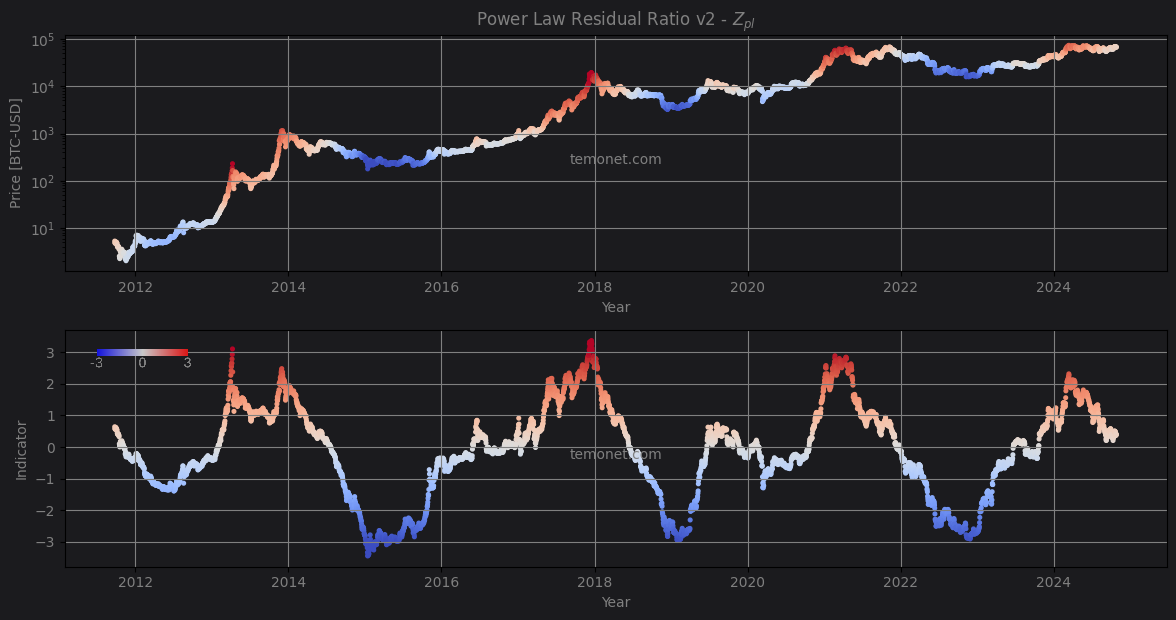

In [235]:
# Normalize the color map
norm = mcolors.Normalize(vmin=-3, vmax=3)
cmap = plt.get_cmap('coolwarm')

# Apply color gradient
colors = cmap(norm((price_df['value'])))
plt.figure(figsize=(11.3*1.05, 6*1.05), facecolor='#1b1b1e')
plt.subplot(211)
ax1 = plt.gca()
ax1.set_facecolor("#1b1b1e")
plt.title('Power Law Residual Ratio v2 - $Z_{pl}$', color='gray')
plt.scatter(price_df.index[T_span[-1]:],price_df['Close'][T_span[-1]:], c=colors[T_span[-1]:], s=7)
plt.yscale('log')
plt.grid(True, color='gray')
plt.xticks(color='gray')
plt.yticks(color='gray')
plt.text(0.5, 0.5, 'temonet.com', transform=plt.gca().transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')

plt.xlabel('Year', color='gray')
plt.ylabel('Price [BTC-USD]', color='gray')

plt.subplot(212)
ax2 = plt.gca()
ax2.set_facecolor("#1b1b1e")
plt.scatter(price_df.index, price_df['value'], c=colors, s=7)
plt.grid(True, color='gray')
plt.xticks(color='gray')
plt.yticks(color='gray')
plt.xlabel('Year', color='gray')
plt.ylabel('Indicator', color='gray')
plt.text(0.5, 0.5, 'temonet.com', transform=plt.gca().transAxes, fontsize=10, color='gray', horizontalalignment='center', verticalalignment='top')
plt.tight_layout()
image = plt.imread('zpl_scale.png')
imagebox = AnnotationBbox(OffsetImage(image, zoom=0.13), (0.07, 0.85), frameon=False, xycoords='axes fraction')
plt.gca().add_artist(imagebox)
plt.savefig('/Users/ashwinsridhar/Documents/Projects/assridha.github.io/assets/img/Zpl.png', bbox_inches='tight', pad_inches=0.1, dpi=1200, facecolor='#1b1b1e')
plt.savefig('/Users/ashwinsridhar/Documents/Projects/assridha.github.io/assets/img/Zpl_lowres.png', bbox_inches='tight', pad_inches=0.1, dpi=300, facecolor='#1b1b1e')
plt.show()
